# Time to get your hands dirty. SDSS Galaxies vs quasars
We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey.

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g.

- Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra Clarke et al (2019) arXiv:1909.10963
- Quasar and galaxy classification in Gaia Data Release 2 Bailer-Jones et al (2019) arXiv:1910.05255

## Data
The dataset is at solutions/galaxyquasar.csv. I have extracted it myself from the SDSS database using the SQL query reported here

(If you've never used SQL and want to learn something new in computing, it's very powerful)

## Tasks
- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$ and $(i-z)$. Also create an array with the class labels where galaxy=1 and quasar=0. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

## Ideas
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?

In [26]:
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('galaxyquasar.csv') # Load data from CSV file into a DataFrame
df

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [8]:
a=df["u"]-df["g"].to_numpy() # u-g color
b=df["g"]-df["r"].to_numpy() # g-r color
c=df["r"]-df["i"].to_numpy() # r-i color
d=df["i"]-df["z"].to_numpy() # i-z color
X = np.column_stack((a, b, c, d))
feature_names = ["u-g", "g-r", "r-i", "i-z"]

In [15]:
labels=[]
for i in df["class"]:
    if(i=="QSO"):   # Label quasars (QSO) as 1
        labels.append(1)
    if(i=="GALAXY"):
        labels.append(0) # Label galaxies as 0

labels=np.array(labels)

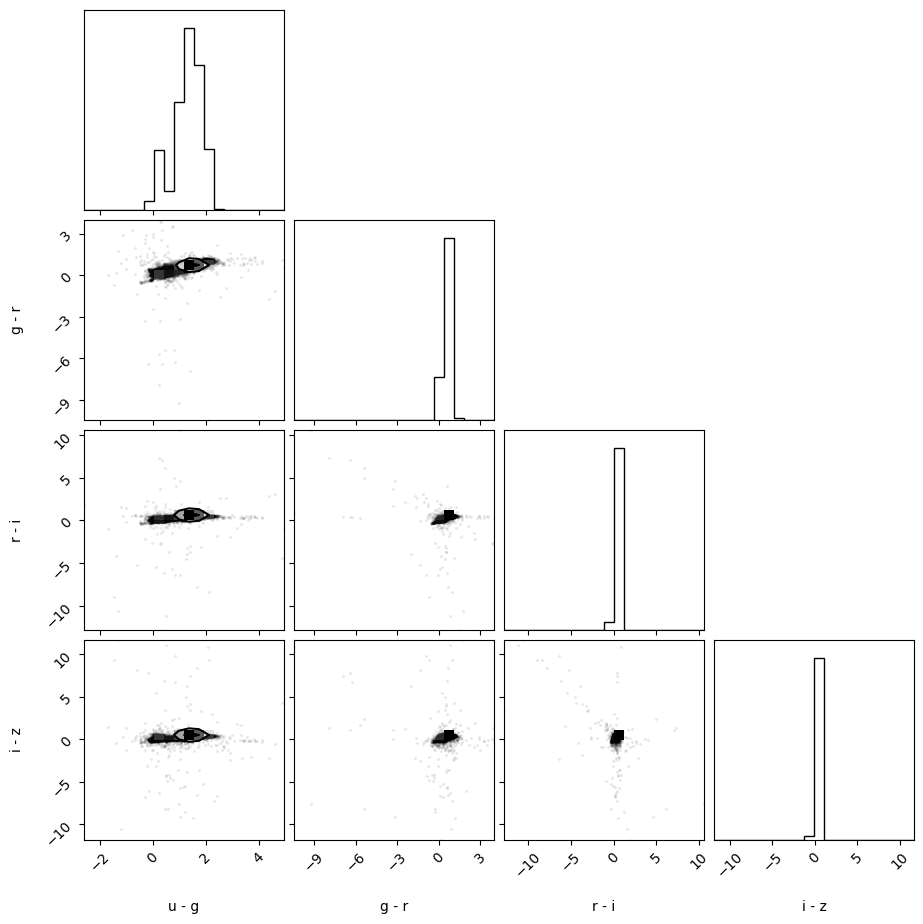

In [6]:
import corner
corner.corner(np.array([a, b, c, d]).T, labels=['u - g', 'g - r', 'r - i', 'i - z']);

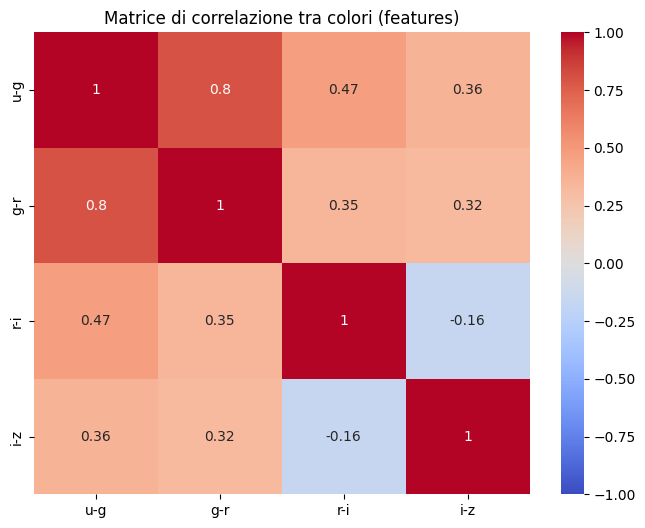

In [ ]:
# Analyze feature correlations
colors_df = pd.DataFrame(X, columns=feature_names)
corr_matrix = colors_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice di correlazione tra colori (features)")
plt.show()

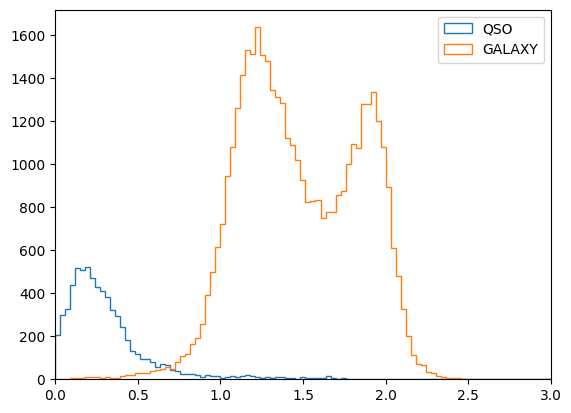

In [ ]:
# Compare 'u-g' distributions between QSOs and Galaxies to see its discriminative power.
plt.hist(a[labels == 1], histtype='step', bins=np.linspace(0, 3, 100), label='QSO')
plt.hist(a[labels == 0], histtype='step', bins=np.linspace(0, 3, 100), label='GALAXY')
plt.xlim(0, 3)
plt.legend()
plt.show()

In [7]:
# Split data into training and testing sets (80% train, 20% test)
X_train,X_test, labels_train, labels_test= train_test_split(X,labels,test_size=0.2, random_state=42)

## Gaussian NB

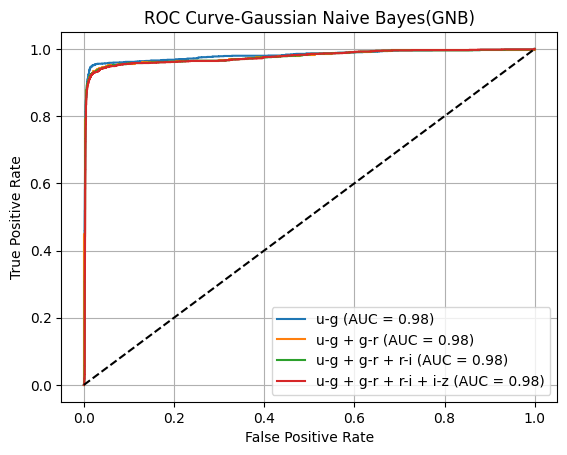

In [18]:
gnb = GaussianNB() # Initialize Gaussian Naive Bayes classifier
feature_names = ["u-g", "g-r", "r-i", "i-z"]
#Loop through 1 to 4 features, each time training and evaluating the model with an increasing number of features to see how performance improves.
for i in range(4):
    # Select first (i+1) features for train and test
    X_train_subset = X_train[:, :i+1]
    X_test_subset = X_test[:, :i+1]

    gnb.fit(X_train_subset, labels_train)
    y_prob = gnb.predict_proba(X_test_subset)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(labels_test, y_prob)
    roc_auc = auc(fpr, tpr)
    label = f"{' + '.join(feature_names[:i+1])} (AUC = {roc_auc:.2f})"
    plt.plot(fpr, tpr, label=label)

# Plot diagonal line
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve-Gaussian Naive Bayes(GNB)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


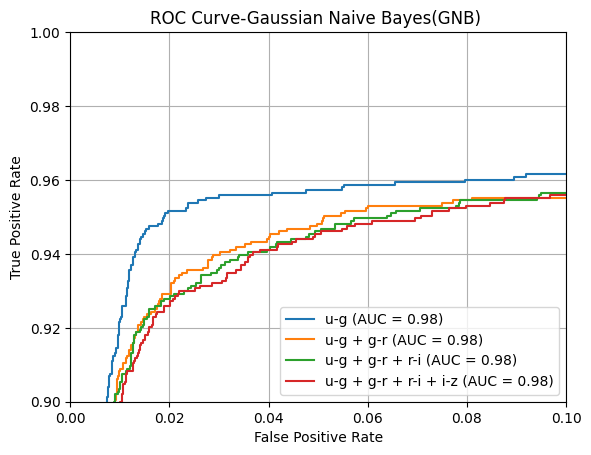

In [ ]:
gnb = GaussianNB() # Initialize Gaussian Naive Bayes classifier
feature_names = ["u-g", "g-r", "r-i", "i-z"]
#Loop through 1 to 4 features, each time training and evaluating the model with an increasing number of features to see how performance improves.
for i in range(4):
    X_train_subset = X_train[:, :i+1]
    X_test_subset = X_test[:, :i+1]

    gnb.fit(X_train_subset, labels_train)
    y_prob = gnb.predict_proba(X_test_subset)[:, 1]


    fpr, tpr, _ = roc_curve(labels_test, y_prob)
    roc_auc = auc(fpr, tpr)
    label = f"{' + '.join(feature_names[:i+1])} (AUC = {roc_auc:.2f})"
    plt.plot(fpr, tpr, label=label)


plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve-Gaussian Naive Bayes(GNB) ")
plt.legend(loc="lower right")
plt.xlim(0,0.1)
plt.ylim(0.9,1)
plt.grid()
plt.show()

## Linear Discriminant Analysis

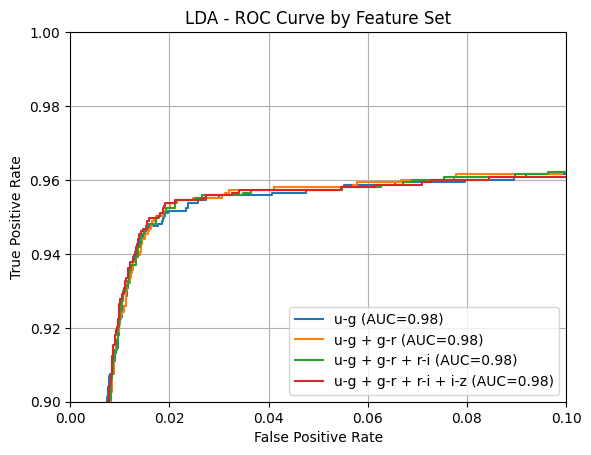

In [ ]:
lda = LinearDiscriminantAnalysis() # Initialize Linear Discriminant Analysis classifier
feature_names = ["u-g", "g-r", "r-i", "i-z"]
#Loop through 1 to 4 features, each time training and evaluating the model with an increasing number of features to see how performance improves.
for i in range(4):
    X_train_sub = X_train[:, :i+1]
    X_test_sub = X_test[:, :i+1]

    lda.fit(X_train_sub, labels_train)
    y_prob = lda.predict_proba(X_test_sub)[:, 1]

    fpr, tpr, _ = roc_curve(labels_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{' + '.join(feature_names[:i+1])} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LDA - ROC Curve by Feature Set")
plt.legend(loc="lower right")
plt.xlim(0,0.1)
plt.ylim(0.9,1)
plt.grid()
plt.show()

## Quadratic Discriminant Analysis

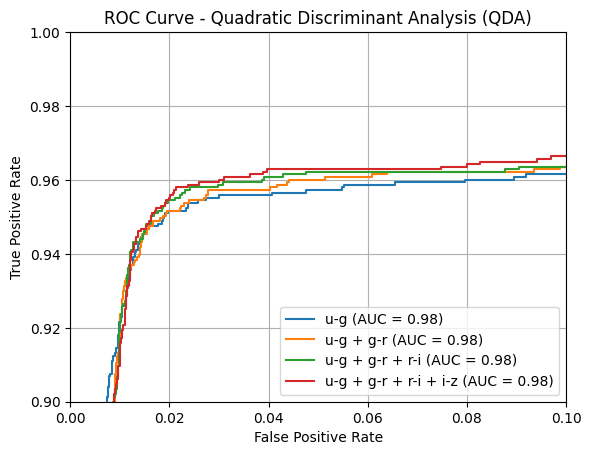

In [21]:
qda = QuadraticDiscriminantAnalysis() # Initialize Quadratic Discriminant Analysis classifier
feature_names = ["u-g", "g-r", "r-i", "i-z"]
#Loop through 1 to 4 features, each time training and evaluating the model with an increasing number of features to see how performance improves.
for i in range(4):
    X_train_subset = X_train[:, :i+1]
    X_test_subset = X_test[:, :i+1]

    qda.fit(X_train_subset, labels_train)
    y_prob = qda.predict_proba(X_test_subset)[:, 1]

   
    fpr, tpr, _ = roc_curve(labels_test, y_prob)
    roc_auc = auc(fpr, tpr)
    label = f"{' + '.join(feature_names[:i+1])} (AUC = {roc_auc:.2f})"
    plt.plot(fpr, tpr, label=label)

plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Quadratic Discriminant Analysis (QDA)")
plt.legend(loc="lower right")
plt.xlim(0,0.1)
plt.ylim(0.9,1)
plt.grid()
plt.show()

## K Neighbors

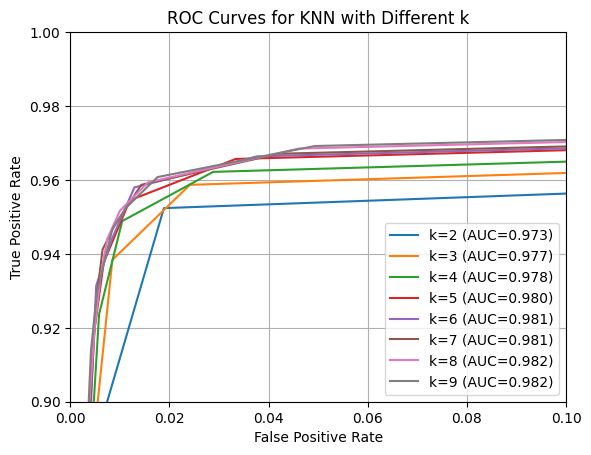

In [22]:
# Loop over different numbers of neighbors
for n in np.arange(2, 10):
    clf = KNeighborsClassifier(n_neighbors=n)     # Initialize KNN with n neighbors
    clf.fit(X_train[:, 0:4], labels_train)             # Train on all 4 features
    
    y_prob = clf.predict_proba(X_test[:, 0:4])[:, 1]  # Predict probabilities for positive class
    
    fpr, tpr, _ = roc_curve(labels_test, y_prob) 
    roc_auc = auc(fpr, tpr)     
    
    plt.plot(fpr, tpr, label=f"k={n} (AUC={roc_auc:.3f})")      

plt.legend()
plt.xlim(0, 0.1)
plt.ylim(0.9, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for KNN with Different k")
plt.grid()
plt.show()



## GMM Bayes

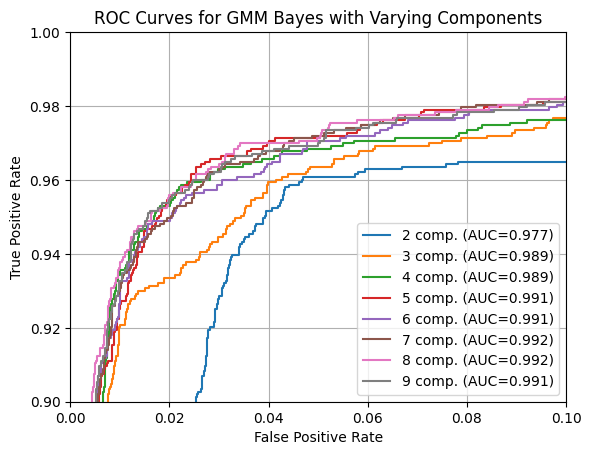

In [25]:
# ROC curves for GMM Bayes with different numbers of Gaussian components
for n in np.arange(2, 10, 1):
    clf = GMMBayes(n_components=n)
    clf.fit(X_train, labels_train)

    y_prob = clf.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(labels_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{n} comp. (AUC={roc_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.legend()
plt.xlim(0, 0.1)
plt.ylim(0.9, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for GMM Bayes with Varying Components")
plt.grid()
plt.show()

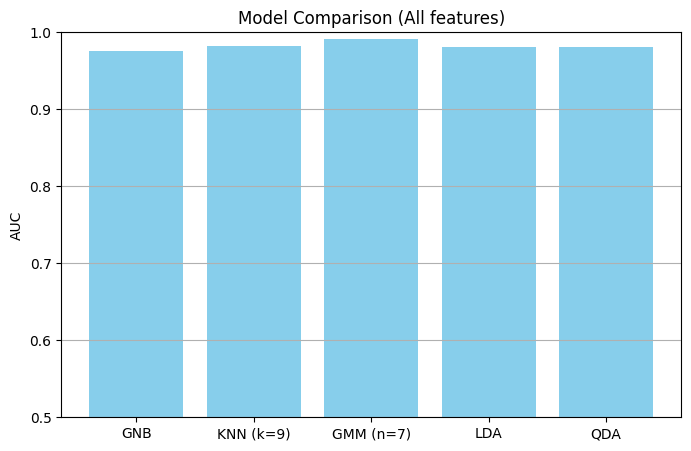

In [27]:

auc_scores = {}

# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, labels_train)
y_prob = gnb.predict_proba(X_test)[:, 1]
auc_scores['GNB'] = roc_auc_score(labels_test, y_prob)

# Best KNN
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, labels_train)
y_prob = knn.predict_proba(X_test)[:, 1]
auc_scores['KNN (k=9)'] = roc_auc_score(labels_test, y_prob)

# Best GMM
gmm = GMMBayes(n_components=7)
gmm.fit(X_train, labels_train)
y_prob = gmm.predict_proba(X_test)[:, 1]
auc_scores['GMM (n=7)'] = roc_auc_score(labels_test, y_prob)

# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, labels_train)
y_prob = lda.predict_proba(X_test)[:, 1]
auc_scores['LDA'] = roc_auc_score(labels_test, y_prob)

# QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, labels_train)
y_prob = qda.predict_proba(X_test)[:, 1]
auc_scores['QDA'] = roc_auc_score(labels_test, y_prob)

# Plot bar chart of AUCs
plt.figure(figsize=(8,5))
plt.bar(auc_scores.keys(), auc_scores.values(), color='skyblue')
plt.ylabel("AUC")
plt.title("Model Comparison (All features)")
plt.ylim(0.5, 1)
plt.grid(axis='y')
plt.show()
